ref: https://github.com/aitorzip/PyTorch-CycleGAN

# Download Dataset

In [ ]:
!nvidia-smi -L

In [ ]:
! mkdir datasets

In [ ]:
! pip install torch torchvision

In [ ]:
! python -c "import torch; print('torch version: ', torch.__version__)"
! python -c "import torchvision; print('torchvision version: ', torchvision.__version__)"

In [ ]:
! mkdir cyclegan
! mkdir cyclegan/model cyclegan/fig

In [ ]:
%%bash
FILE="summer2winter_yosemite"
URL=https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/$FILE.zip
ZIP_FILE=./datasets/$FILE.zip
TARGET_DIR=./datasets/$FILE
mkdir -p ./datasets
wget -N $URL -O $ZIP_FILE
unzip $ZIP_FILE -d ./datasets/
rm $ZIP_FILE

# Adapt to project expected directory heriarchy
mkdir -p "$TARGET_DIR/train" "$TARGET_DIR/test"
mv "$TARGET_DIR/trainA" "$TARGET_DIR/train/A"
mv "$TARGET_DIR/trainB" "$TARGET_DIR/train/B"
mv "$TARGET_DIR/testA" "$TARGET_DIR/test/A"
mv "$TARGET_DIR/testB" "$TARGET_DIR/test/B"

# Data Handle

In [1]:
model_name = "cyclegan"

In [2]:
import glob
import random
import os

from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms

class ImageDataset(Dataset):
    def __init__(self, root, transforms_=None, unaligned=False, mode='train'):
        self.transform = transforms.Compose(transforms_)
        self.unaligned = unaligned

        self.files_A = sorted(glob.glob(os.path.join(root, '%s/A' % mode) + '/*.*'))
        self.files_B = sorted(glob.glob(os.path.join(root, '%s/B' % mode) + '/*.*'))

    def __getitem__(self, index):
        item_A = self.transform(Image.open(self.files_A[index % len(self.files_A)]))

        if self.unaligned:
            item_B = self.transform(Image.open(self.files_B[random.randint(0, len(self.files_B) - 1)]))
        else:
            item_B = self.transform(Image.open(self.files_B[index % len(self.files_B)]))

        return {'A': item_A, 'B': item_B}

    def __len__(self):
        return max(len(self.files_A), len(self.files_B))

In [3]:
# Dataset loader
from torch.utils.data import DataLoader
batch_size = 1
img_size = 256
transforms_ = [ transforms.Resize(int(img_size*1.12), Image.BICUBIC), 
                transforms.RandomCrop(img_size), 
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)) ]
dataset = ImageDataset("datasets/summer2winter_yosemite", 
                       transforms_=transforms_, 
                       unaligned=True)
dataloader = DataLoader(dataset, 
                        batch_size=batch_size, 
                        shuffle=True, 
                        num_workers=8)

In [4]:
batch = next(iter(dataloader))
batch['A'].shape, batch['B'].shape

(torch.Size([1, 3, 256, 256]), torch.Size([1, 3, 256, 256]))

# Model

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [6]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()

        conv_block = [  nn.ReflectionPad2d(1),
                        nn.Conv2d(in_features, in_features, 3),
                        nn.InstanceNorm2d(in_features),
                        nn.ReLU(inplace=True),
                        nn.ReflectionPad2d(1),
                        nn.Conv2d(in_features, in_features, 3),
                        nn.InstanceNorm2d(in_features)  ]

        self.conv_block = nn.Sequential(*conv_block)

    def forward(self, x):
        return x + self.conv_block(x)
    
class Generator(nn.Module):
    def __init__(self, input_nc, output_nc, n_residual_blocks=3): # 9-->5
        super(Generator, self).__init__()

        # Initial convolution block       
        model = [   nn.ReflectionPad2d(3),
                    nn.Conv2d(input_nc, 64, 7),
                    nn.InstanceNorm2d(64),
                    nn.ReLU(inplace=True) ]

        # Downsampling
        in_features = 64
        out_features = in_features*2
        for _ in range(2):
            model += [  nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                        nn.InstanceNorm2d(out_features),
                        nn.ReLU(inplace=True) ]
            in_features = out_features
            out_features = in_features*2

        # Residual blocks
        for _ in range(n_residual_blocks):
            model += [ResidualBlock(in_features)]

        # Upsampling
        out_features = in_features//2
        for _ in range(2):
            model += [  nn.ConvTranspose2d(in_features, out_features, 3, stride=2, padding=1, output_padding=1),
                        nn.InstanceNorm2d(out_features),
                        nn.ReLU(inplace=True) ]
            in_features = out_features
            out_features = in_features//2

        # Output layer
        model += [  nn.ReflectionPad2d(3),
                    nn.Conv2d(64, output_nc, 7),
                    nn.Tanh() ]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)
    
class Discriminator(nn.Module):
    def __init__(self, input_nc):
        super(Discriminator, self).__init__()

        # A bunch of convolutions one after another
        model = [   nn.Conv2d(input_nc, 64, 4, stride=2, padding=1),
                    nn.LeakyReLU(0.2, inplace=True) ]

        model += [  nn.Conv2d(64, 128, 4, stride=2, padding=1),
                    nn.InstanceNorm2d(128), 
                    nn.LeakyReLU(0.2, inplace=True) ]

        model += [  nn.Conv2d(128, 256, 4, stride=2, padding=1),
                    nn.InstanceNorm2d(256), 
                    nn.LeakyReLU(0.2, inplace=True) ]

        model += [  nn.Conv2d(256, 512, 4, padding=1),
                    nn.InstanceNorm2d(512), 
                    nn.LeakyReLU(0.2, inplace=True) ]


        # FCN classification layer
        model += [nn.Conv2d(512, 1, 4, padding=1)]

        self.model = nn.Sequential(*model)
        
    def forward(self, x):
        x =  self.model(x)
        # Average pooling and flatten
        return F.avg_pool2d(x, x.size()[2:]).view(x.size()[0], -1)

In [7]:
# Networks
use_cuda = True
input_nc, output_nc = 3,3
netG_A2B = Generator(input_nc, output_nc)
netG_B2A = Generator(output_nc, input_nc)
netD_A = Discriminator(input_nc)
netD_B = Discriminator(output_nc)

if use_cuda:
    netG_A2B.cuda()
    netG_B2A.cuda()
    netD_A.cuda()
    netD_B.cuda()

In [8]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1:
        torch.nn.init.normal(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant(m.bias.data, 0.0)
        
        
netG_A2B.apply(weights_init_normal)
netG_B2A.apply(weights_init_normal)
netD_A.apply(weights_init_normal)
netD_B.apply(weights_init_normal)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  after removing the cwd from sys.path.


Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (9): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  )
)

In [9]:
# Lossess
criterion_GAN = torch.nn.MSELoss()
criterion_cycle = torch.nn.L1Loss()
criterion_identity = torch.nn.L1Loss()

summer2winter


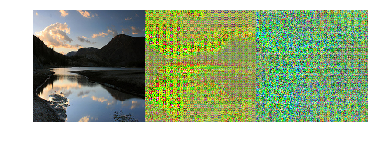

winter2summer


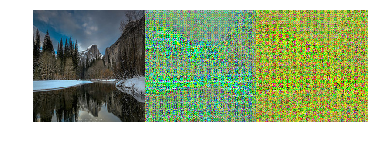

In [10]:
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import torch
%matplotlib inline
rescale_fn = lambda t : torch.clamp(((t+1)*0.5*256).long(), min=0, max=255)
def show_img(img):
    data = rescale_fn(img).cpu().detach().numpy().transpose((1, 2, 0))
    plt.axis('off')
    imgplot = plt.imshow(data)
    
def show_imgs(imgs, n_height=1, n_width=1):  # imgs: torch.Size([64, 3, 28, 28])
    assert len(imgs) == n_height* n_width
    imgs = rescale_fn(imgs).cpu().detach().numpy().transpose((0, 2, 3, 1))
    fig = plt.figure(figsize = (n_height, n_width) )
    gs1 = gridspec.GridSpec(n_height, n_width,  left=0, bottom=0, right=0.75, top=1 )
    gs1.update(wspace=0.0, hspace=0.05) # set the spacing between axes.
    for i in range(len(imgs)):
        plottable_image = imgs[i]
        # i = i + 1 # grid spec indexes from 0
        ax = plt.subplot(gs1[i])
        ax.axis('off')
        ax.set_aspect('equal')
        ax.imshow(plottable_image)
        
def sample_img(G_to, G_back, data_loader, AorB="A", PATH="test.jpg"):
    G_to.eval()
    G_back.eval()
    imgs_batch = next(iter(data_loader))
    imgs_batch = imgs_batch[AorB]
    if use_cuda: imgs_batch = imgs_batch.cuda()
    imgs_to_batch = G_to(imgs_batch)
    imgs_back_batch = G_back(imgs_to_batch)
    imgs_dual_batch = torch.cat((imgs_batch, imgs_to_batch, imgs_back_batch), 3)
    show_img(imgs_dual_batch[0]) #印整個batch出來看
    plt.savefig(PATH)
    plt.show()
    G_to.train()
    G_back.train()

# before load
print('summer2winter');sample_img(netG_A2B,  netG_B2A, dataloader, AorB="A")
print('winter2summer');sample_img(netG_B2A,  netG_A2B, dataloader, AorB="B")

# Train

In [11]:
# Optimizers 
import itertools
lr = 0.0001
optimizer_G = torch.optim.Adam(itertools.chain(netG_A2B.parameters(), netG_B2A.parameters()),
                                lr=lr, betas=(0.5, 0.999))
optimizer_D_A = torch.optim.Adam(netD_A.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D_B = torch.optim.Adam(netD_B.parameters(), lr=lr, betas=(0.5, 0.999))

In [12]:
# Inputs & targets memory allocation
Tensor = torch.cuda.FloatTensor if use_cuda else torch.Tensor
input_A = Tensor(batch_size, input_nc, img_size, img_size)
input_B = Tensor(batch_size, output_nc, img_size, img_size)
target_real = Tensor(batch_size).fill_(1.0)
target_fake = Tensor(batch_size).fill_(0.0)

In [13]:
class LambdaLR():
    def __init__(self, n_epochs, offset, decay_start_epoch):
        assert ((n_epochs - decay_start_epoch) > 0), "Decay must start before the training session ends!"
        self.n_epochs = n_epochs
        self.offset = offset
        self.decay_start_epoch = decay_start_epoch

    def step(self, epoch):
        return 1.0 - max(0, epoch + self.offset - self.decay_start_epoch)/(self.n_epochs - self.decay_start_epoch)

    
start_epo = 0
n_epochs = 200
decay_epoch = 100
lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=LambdaLR(n_epochs, start_epo, decay_epoch).step)
lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(optimizer_D_A, lr_lambda=LambdaLR(n_epochs, start_epo, decay_epoch).step)
lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(optimizer_D_B, lr_lambda=LambdaLR(n_epochs, start_epo, decay_epoch).step)


/opt/conda/lib/python3.6/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[Epoch 0/200] [loss_D_A loss: 0.159022] [loss_D_A loss: 0.478734] [G loss: 5.850583]
summer2winter:


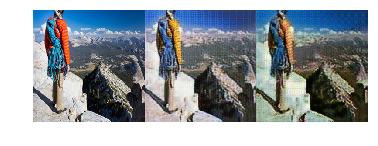

winter2summer:


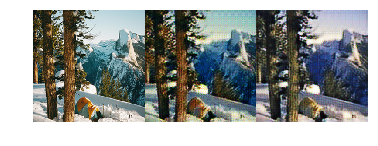

[Epoch 9/200] [loss_D_A loss: 0.178963] [loss_D_A loss: 0.274575] [G loss: 4.619227]
summer2winter:


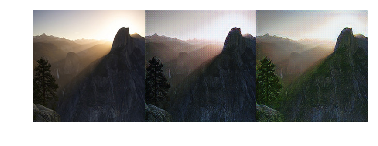

winter2summer:


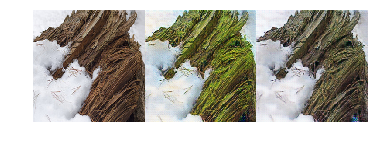

[Epoch 19/200] [loss_D_A loss: 0.071777] [loss_D_A loss: 0.046966] [G loss: 4.098543]
summer2winter:


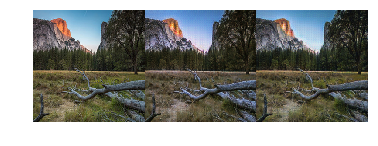

winter2summer:


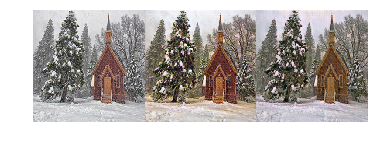

[Epoch 29/200] [loss_D_A loss: 0.015851] [loss_D_A loss: 0.028275] [G loss: 3.903751]
summer2winter:


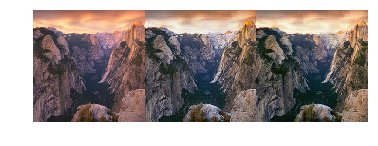

winter2summer:


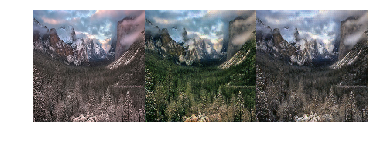

[Epoch 39/200] [loss_D_A loss: 0.279646] [loss_D_A loss: 0.319642] [G loss: 4.061170]
summer2winter:


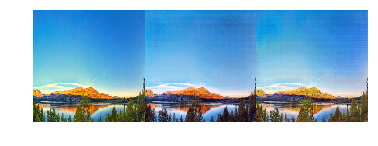

winter2summer:


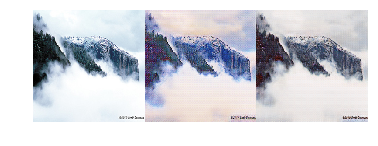

In [ ]:
###### Training ######
print_freq = 10
netG_A2B.train()
netG_B2A.train()
netD_A.train()
netD_B.train()
for epoch in range(n_epochs):
    for i, batch in enumerate(dataloader):
        # Set model input
        real_A = input_A.copy_(batch['A'])
        real_B = input_B.copy_(batch['B'])

        ###### Generators A2B and B2A ######
        optimizer_G.zero_grad()

        # Identity loss
        # G_A2B(B) should equal B if real B is fed
        same_B = netG_A2B(real_B)
        loss_identity_B = criterion_identity(same_B, real_B)*5.0
        # G_B2A(A) should equal A if real A is fed
        same_A = netG_B2A(real_A)
        loss_identity_A = criterion_identity(same_A, real_A)*5.0

        # GAN loss
        fake_B = netG_A2B(real_A)
        pred_fake = netD_B(fake_B)
        loss_GAN_A2B = criterion_GAN(pred_fake, target_real)

        fake_A = netG_B2A(real_B)
        pred_fake = netD_A(fake_A)
        loss_GAN_B2A = criterion_GAN(pred_fake, target_real)

        # Cycle loss
        recovered_A = netG_B2A(fake_B)
        loss_cycle_ABA = criterion_cycle(recovered_A, real_A)*10.0

        recovered_B = netG_A2B(fake_A)
        loss_cycle_BAB = criterion_cycle(recovered_B, real_B)*10.0

        # Total loss
        loss_G = loss_identity_A + loss_identity_B + loss_GAN_A2B + loss_GAN_B2A + loss_cycle_ABA + loss_cycle_BAB
        loss_G.backward()
        
        optimizer_G.step()
        ###################################

        ###### Discriminator A ######
        optimizer_D_A.zero_grad()

        # Real loss
        pred_real = netD_A(real_A)
        loss_D_real = criterion_GAN(pred_real, target_real)

        # Fake loss
        pred_fake = netD_A(fake_A.detach())
        loss_D_fake = criterion_GAN(pred_fake, target_fake)

        # Total loss
        loss_D_A = (loss_D_real + loss_D_fake)*0.5
        loss_D_A.backward()

        optimizer_D_A.step()
        ###################################

        ###### Discriminator B ######
        optimizer_D_B.zero_grad()

        # Real loss
        pred_real = netD_B(real_B)
        loss_D_real = criterion_GAN(pred_real, target_real)
        
        # Fake loss
        pred_fake = netD_B(fake_B.detach())
        loss_D_fake = criterion_GAN(pred_fake, target_fake)

        # Total loss
        loss_D_B = (loss_D_real + loss_D_fake)*0.5
        loss_D_B.backward()

        optimizer_D_B.step()
        ###################################

    # Update learning rates
    lr_scheduler_G.step()
    lr_scheduler_D_A.step()
    lr_scheduler_D_B.step()
    
    if epoch==0 or epoch%print_freq==(print_freq-1) or epoch==n_epochs-1:         
        print(
            "[Epoch %d/%d] [loss_D_A loss: %f] [loss_D_A loss: %f] [G loss: %f]"
            % (epoch, n_epochs, loss_D_A.item(), loss_D_B.item(),loss_G.item())
        )
        # save out
        this_epo_str = str(epoch+start_epo).zfill(4) 
        torch.save(netG_A2B.state_dict(), f"{model_name}/model/netG_A2B_{this_epo_str}")
        torch.save(netG_B2A.state_dict(), f"{model_name}/model/netG_B2A_{this_epo_str}")
        torch.save(netD_A.state_dict(), f"{model_name}/model/netD_A_{this_epo_str}")
        torch.save(netD_B.state_dict(), f"{model_name}/model/netD_B_{this_epo_str}")
        
        print('summer2winter:')
        sample_img(netG_A2B,  netG_B2A, dataloader, "A", f"{model_name}/fig/{this_epo_str}_summer2winter.jpg")
        print('winter2summer:')
        sample_img(netG_B2A,  netG_A2B, dataloader, "B", f"{model_name}/fig/{this_epo_str}_winter2summer.jpg")
    
    ###################################